In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

In [31]:
# import the data
dataset = pd.read_parquet('../ourdata/drifting_dataset_session_798911424.parquet')
dataset

,stimulus_presentation_id,unit_id,orientation,temporal_frequency,spikes_per_second,area
0,3798,951088664,0.0,15.0,12.489571,APN
1,3798,951088679,0.0,15.0,11.989988,APN
2,3798,951088721,0.0,15.0,12.489571,APN
3,3798,951088823,0.0,15.0,0.999166,APN
4,3798,951088862,0.0,15.0,38.967462,APN
...,...,...,...,...,...,...
396805,49432,951117127,180.0,1.0,11.490348,VISrl
396806,49432,951117252,180.0,1.0,10.990768,LP
396807,49432,951117258,180.0,1.0,2.997482,LP
396808,49432,951117264,180.0,1.0,10.491187,LP


We now take a look at the areas of the brain in our dataset:

In [32]:
# see the different areas of the brain in our dataset
dataset['area'].unique()

array(['APN', 'MB', 'NOT', 'DG', 'CA1', 'VISam', 'LP', 'ProS', 'SUB',
       'VISp', 'CA3', 'VISl', 'LGv', 'CA2', 'VISal', 'TH', 'Eth', 'VISrl'],
      dtype=object)

In [33]:
n_classes = len(dataset['area'].unique())

In [6]:
# dataset['area'] = dataset['area'].apply(lambda x: 
#     'Visual' if x in ['VISp', 'VISal', 'VISmma', 'VISrl', 'VISam', 'VISl'] else 
#     'Hippocampus' if x in ['CA1', 'CA2', 'CA3', 'DG', 'SUB', 'ProS'] else 
#     'Thalamus' if x in ['LP', 'LGd', 'POL', 'APN'] else 
#     'Other') 

In [34]:
# we drop the rows with nans
dataset = dataset.dropna()
print(dataset.shape[0])

378168


In [35]:
# we filter for neurons that are spiking
dataset = dataset[dataset['spikes_per_second'] > 50]
dataset

,stimulus_presentation_id,unit_id,orientation,temporal_frequency,spikes_per_second,area
7,3798,951088948,0.0,15.0,66.944102,APN
11,3798,951089020,0.0,15.0,64.945770,APN
19,3798,951089195,0.0,15.0,84.429501,NOT
23,3798,951089488,0.0,15.0,81.432004,NOT
24,3798,951089538,0.0,15.0,70.940764,NOT
...,...,...,...,...,...,...
396537,49432,951107266,180.0,1.0,64.445865,CA1
396546,49432,951108120,180.0,1.0,72.938731,CA1
396614,49432,951110614,180.0,1.0,66.444187,LGv
396615,49432,951110620,180.0,1.0,55.453419,LGv


## Clustering

We now try to use two unsupervised algorithms to cluster the data (KMeans and DBSCAN)

In [9]:
#dataset = dataset.sample(22000, random_state=42)

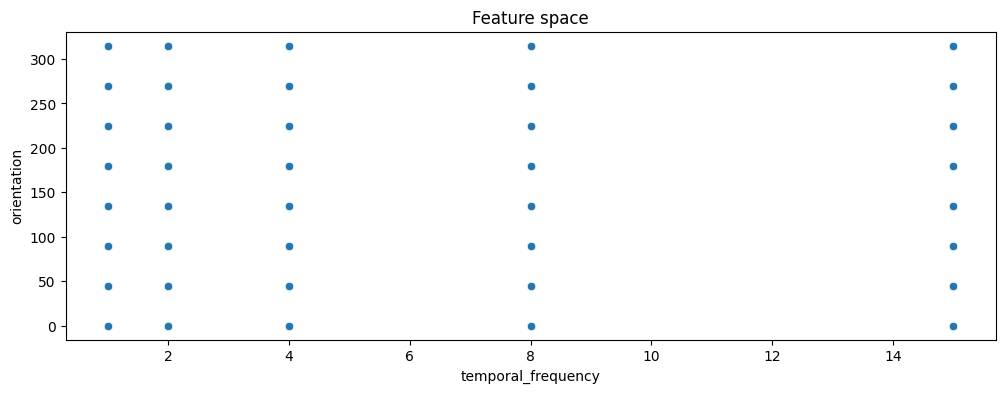

In [36]:
plt.figure(figsize=(12, 4))
sns.scatterplot(x=dataset['temporal_frequency'], y=dataset['orientation'])
plt.title('Feature space')
plt.show()

As the feature space has few elements and is rather regular, we do not expect unsupervised algorithms to work effectively

In [37]:
features = ['temporal_frequency', 'orientation']
X = dataset[features]
Y = dataset['area']  

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

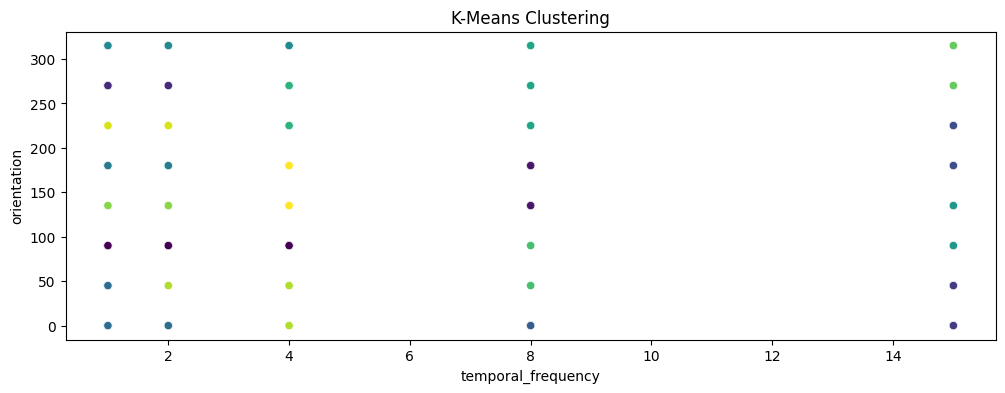

In [43]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_classes, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

dataset['KMeans_Cluster'] = kmeans_labels

# Visualize K-Means Clusters
plt.figure(figsize=(12, 4))
sns.scatterplot(x=dataset['temporal_frequency'], y=dataset['orientation'], hue=dataset['KMeans_Cluster'], palette='viridis', legend=False)
plt.title('K-Means Clustering')
plt.show()

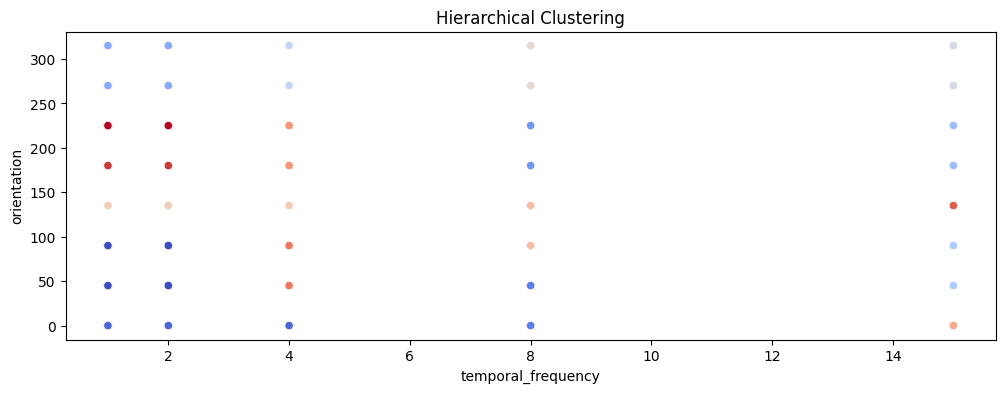

In [41]:
# Apply Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=n_classes)
agglo_labels = agglo.fit_predict(X_scaled)
dataset['Hierarchical_Cluster'] = agglo_labels

# Visualize Hierarchical Clusters
plt.figure(figsize=(12, 4))
sns.scatterplot(x=dataset['temporal_frequency'], y=dataset['orientation'], hue=dataset['Hierarchical_Cluster'], palette='coolwarm', legend=False)
plt.title('Hierarchical Clustering')
plt.show()

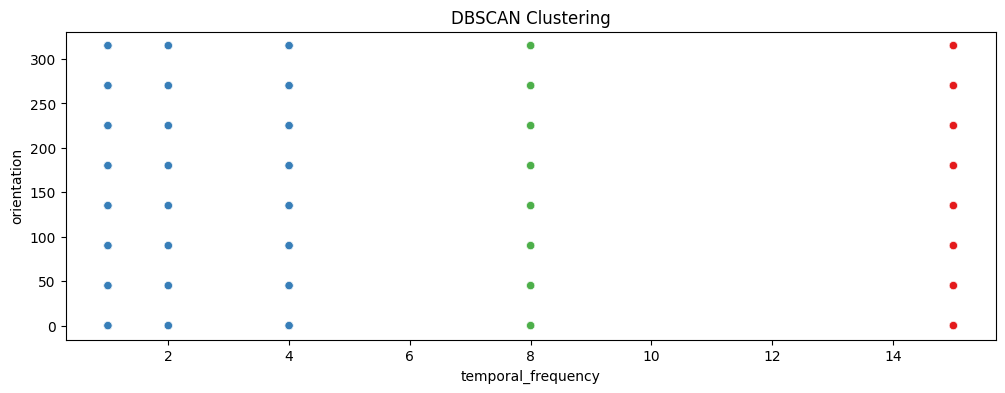

In [47]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
dataset['DBSCAN_Cluster'] = dbscan_labels

# Visualize DBSCAN Clusters
plt.figure(figsize=(12, 4))
sns.scatterplot(x=dataset['temporal_frequency'], y=dataset['orientation'], hue=dataset['DBSCAN_Cluster'], palette='Set1', legend=False)
plt.title('DBSCAN Clustering')
plt.show()

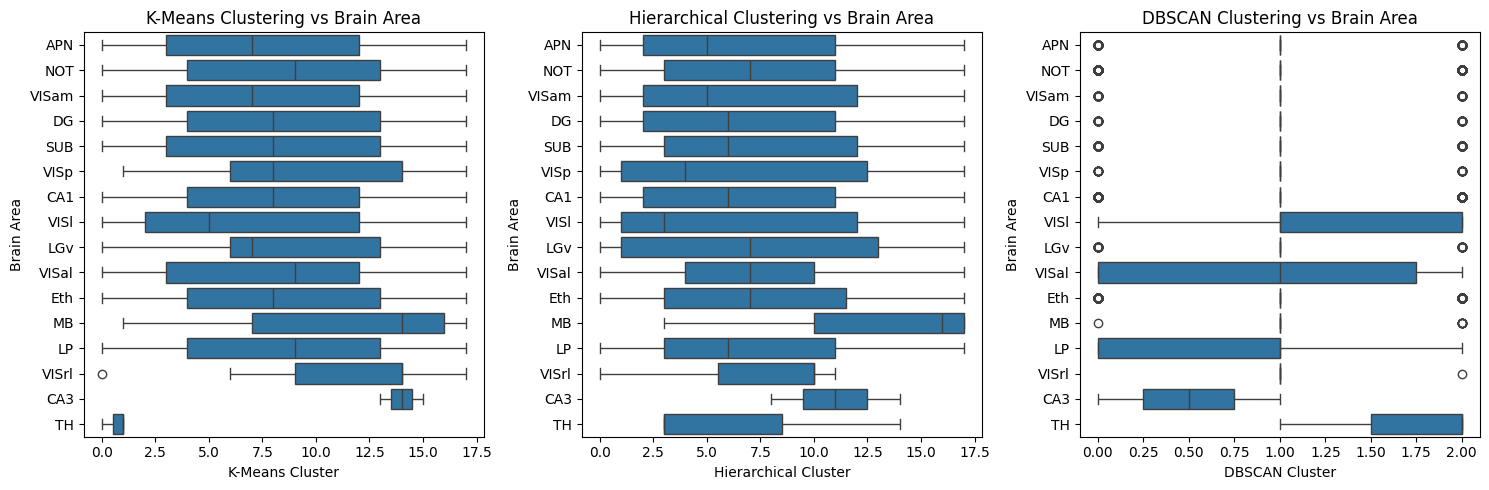

In [48]:
plt.figure(figsize=(15, 5))

# Plot for K-Means Clustering
plt.subplot(1, 3, 1)
sns.boxplot(x='KMeans_Cluster', y='area', data=dataset)
plt.title('K-Means Clustering vs Brain Area')
plt.xlabel('K-Means Cluster')
plt.ylabel('Brain Area')

# Plot for Hierarchical Clustering
plt.subplot(1, 3, 2)
sns.boxplot(x='Hierarchical_Cluster', y='area', data=dataset)
plt.title('Hierarchical Clustering vs Brain Area')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('Brain Area')

# Plot for DBSCAN Clustering
plt.subplot(1, 3, 3)
sns.boxplot(x='DBSCAN_Cluster', y='area', data=dataset)
plt.title('DBSCAN Clustering vs Brain Area')
plt.xlabel('DBSCAN Cluster')
plt.ylabel('Brain Area')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

## Supervised classification: XGBoost

In [49]:
# Split data into training and testing sets
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=10)
xgb_model.fit(X_train, Y_train)

# Make predictions
Y_pred = xgb_model.predict(X_test)

/Users/edoardoghirardo/miniconda/envs/envallen/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/edoardoghirardo/miniconda/envs/envallen/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/edoardoghirardo/miniconda/envs/envallen/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.21      0.04      0.07       166
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00       108
           5       0.00      0.00      0.00        62
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        23
           8       0.35      0.98      0.52       373
           9       0.00      0.00      0.00        89
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00        29
          12       0.00      0.00      0.00        41
          13       0.00      0.00      0.00        17
          14       0.00      0.00      0.00        21
          15       0.00      0.00      0.00         2

    accuracy                           0.35      1074
   macro avg       0.04      0.07      0.04      1074
wei

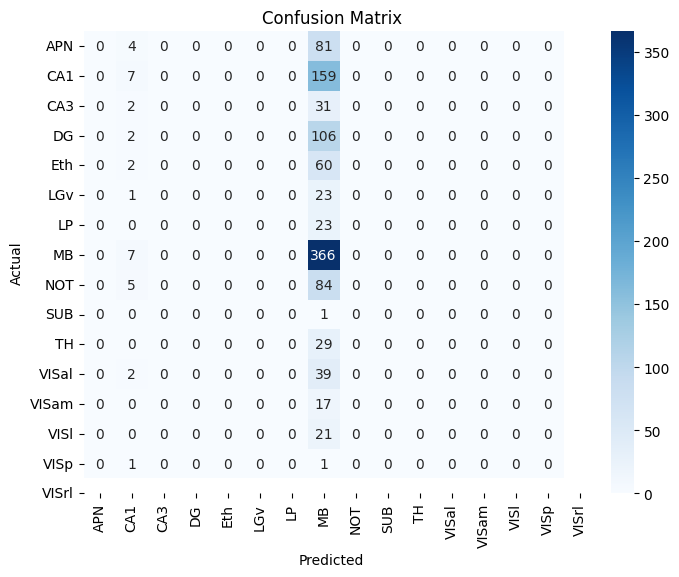

Accuracy: 0.3473


In [50]:
# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)

# Generate classification report
class_report = classification_report(Y_test, Y_pred)

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Display classification report
print("Classification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
print(f'Accuracy: {accuracy:.4f}')

# Compute ROC-AUC score if binary classification
if len(label_encoder.classes_) == 2:
    auc_score = roc_auc_score(Y_test, Y_pred)
    print(f'ROC-AUC Score: {auc_score:.4f}')

In [18]:
dataset

,stimulus_presentation_id,unit_id,orientation,temporal_frequency,spikes_per_second,area,KMeans_Cluster,Hierarchical_Cluster,DBSCAN_Cluster
7,3798,951088948,0.0,15.0,66.944102,APN,3,12,0
11,3798,951089020,0.0,15.0,64.945770,APN,3,12,0
19,3798,951089195,0.0,15.0,84.429501,NOT,3,12,0
23,3798,951089488,0.0,15.0,81.432004,NOT,3,12,0
24,3798,951089538,0.0,15.0,70.940764,NOT,3,12,0
...,...,...,...,...,...,...,...,...,...
396537,49432,951107266,180.0,1.0,64.445865,CA1,7,16,1
396546,49432,951108120,180.0,1.0,72.938731,CA1,7,16,1
396614,49432,951110614,180.0,1.0,66.444187,LGv,7,16,1
396615,49432,951110620,180.0,1.0,55.453419,LGv,7,16,1


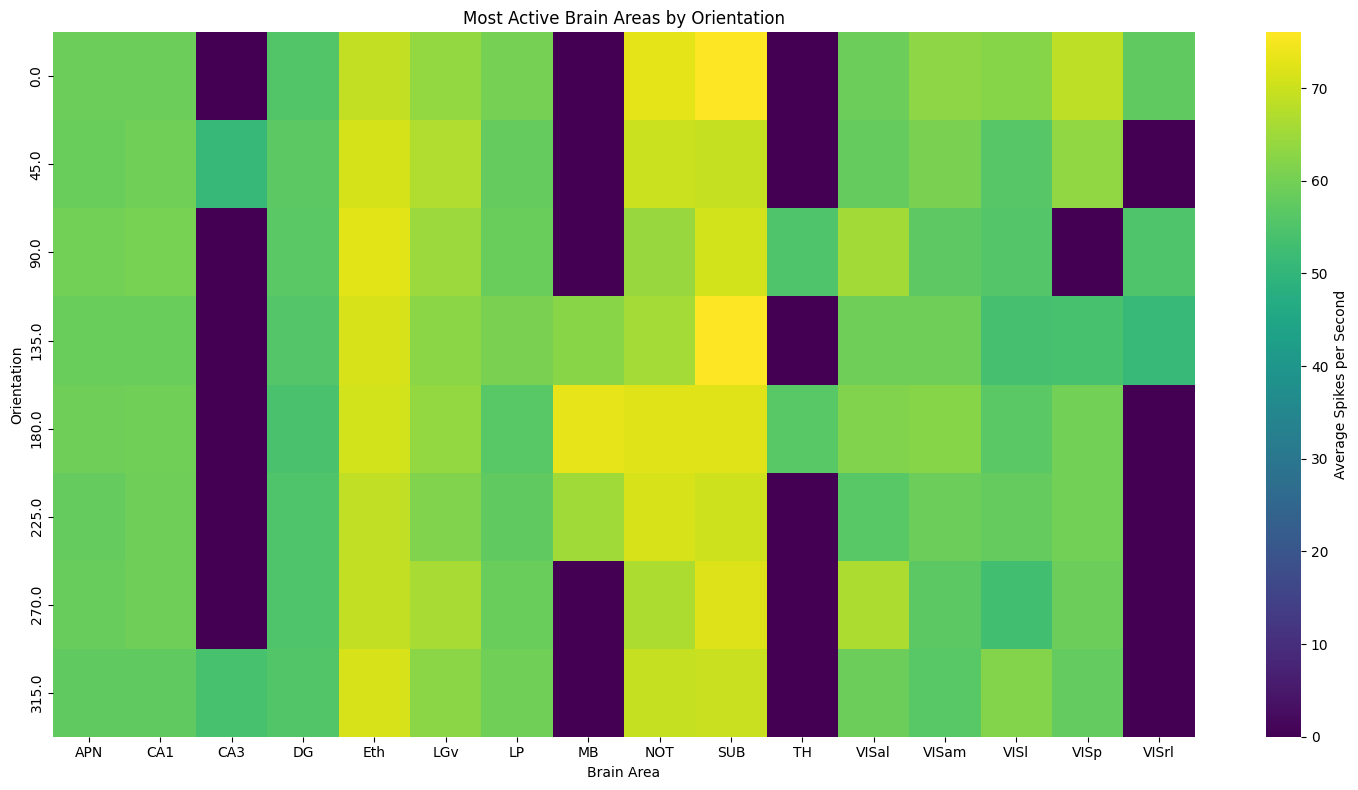

In [ ]:
# Group by orientation and calculate the average spikes_per_second for each area
grouped_orientation = dataset.groupby(['orientation', 'area'])['spikes_per_second'].mean().reset_index()

# Pivot the data for easier visualization
pivot_orientation = grouped_orientation.pivot_table(index='orientation', columns='area', values='spikes_per_second', fill_value=0)

# Plot the heatmap for orientation
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_orientation, cmap='viridis', annot=False, cbar_kws={'label': 'Average Spikes per Second'})
plt.title('Most Active Brain Areas by Orientation')
plt.xlabel('Brain Area')
plt.ylabel('Orientation')
plt.tight_layout()
plt.show()

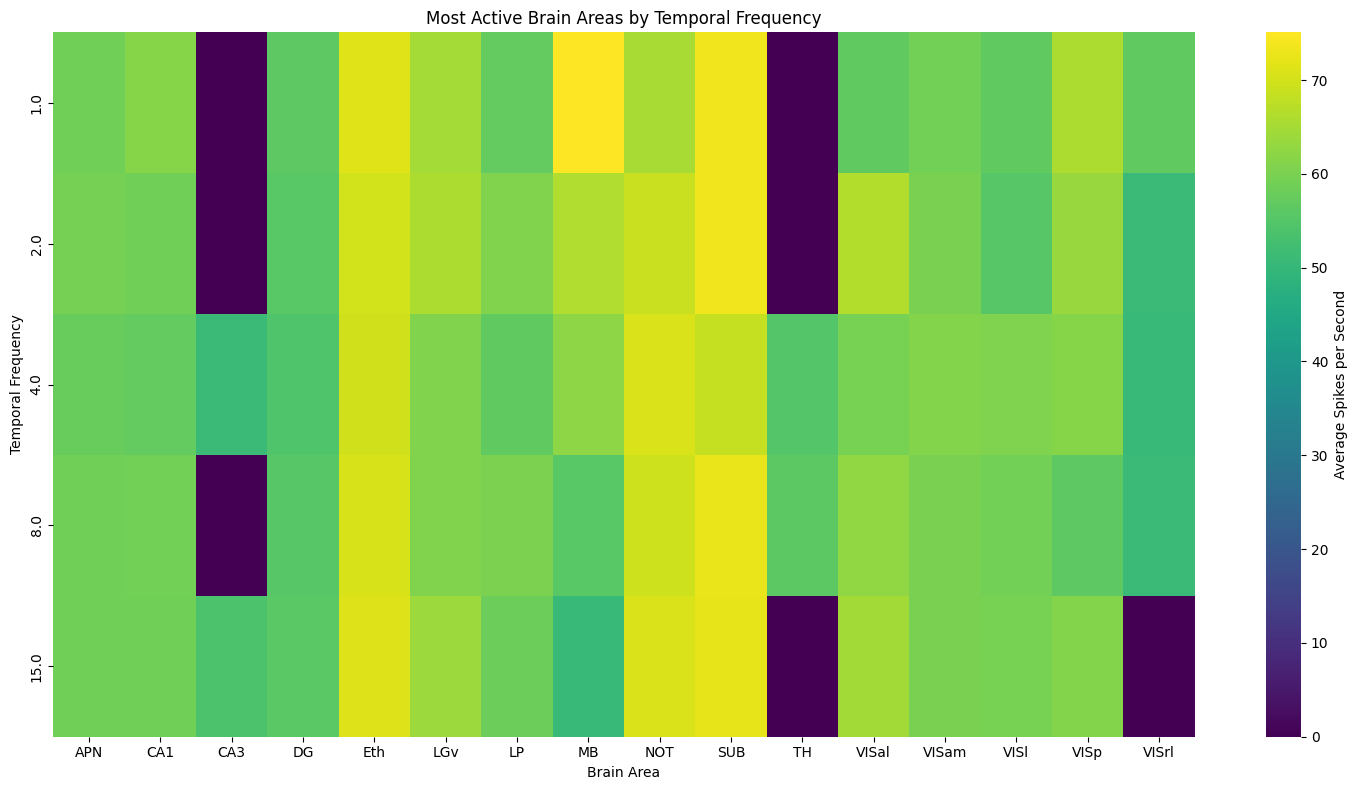

In [21]:
# Group by temporal_frequency and calculate the average spikes_per_second for each area
grouped_frequency = dataset.groupby(['temporal_frequency', 'area'])['spikes_per_second'].mean().reset_index()

# Pivot the data for easier visualization
pivot_frequency = grouped_frequency.pivot_table(index='temporal_frequency', columns='area', values='spikes_per_second', fill_value=0)

# Plot the heatmap for temporal frequency
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_frequency, cmap='viridis', annot=False, cbar_kws={'label': 'Average Spikes per Second'})
plt.title('Most Active Brain Areas by Temporal Frequency')
plt.xlabel('Brain Area')
plt.ylabel('Temporal Frequency')
plt.tight_layout()
plt.show()